In [53]:
import sys
import matplotlib
import scipy as sp
import IPython
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import lightgbm as lgb
import shap
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.utils.class_weight import compute_sample_weight

### Data Import

In [54]:
#read in dataframe of preprocessed data from pre-processing notebook
features = pd.read_excel('df_minmax.xlsx')

In [55]:
#visualise data
features
# make sure there is no additional unnamed first column before KMF, if so delete from excel file and reload df_minmax above

,KMF,Class I TBs,Class II TBs,Number of N3,MW,H Bond Ratio,Oxygen Balance,Num Heteroatoms,Total Rings,Aromatic Rings,...,VSAEState8,Number of N,Number of O,Number of C,NO2 adj to NO2,NO2 adj to NH2,NO2 adj to CO,NO2 adj to CH3,NO2 adj to OH,NO2 adj to NH
0,0.445687,0.669282,0.000000,0.0,0.328747,0.000000,0.802651,0.419355,0.2,0.25,...,0.724917,0.263158,2.564949,1.945910,12,0,0,0,0,0
1,0.361436,0.669282,1.000000,0.0,0.450112,0.000000,0.730874,0.612903,1.0,0.00,...,0.724917,0.578947,2.564949,1.945910,0,0,0,0,0,0
2,0.439340,0.489523,0.856635,0.0,0.258776,0.000000,0.661051,0.354839,0.2,0.00,...,0.470755,0.368421,2.197225,1.609438,0,0,0,0,0,0
3,0.291310,0.370310,0.758654,0.0,0.159034,0.000000,0.661051,0.225806,0.2,0.00,...,0.605911,0.263158,1.945910,1.386294,0,0,0,0,0,0
4,0.303896,0.370310,0.000000,0.0,0.165790,0.000000,0.317995,0.129032,0.2,0.25,...,0.802971,0.105263,1.945910,2.079442,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,0.282750,0.370310,0.000000,0.0,0.169777,0.000000,0.620395,0.193548,0.2,0.25,...,0.724917,0.157895,2.079442,1.791759,0,0,0,0,0,0
481,0.681968,0.803545,0.000000,0.0,0.696799,0.112072,0.439860,0.709677,0.6,0.75,...,0.724917,0.526316,2.833213,2.890372,0,0,0,0,0,6
482,0.624358,0.669282,0.000000,0.0,0.575564,0.138665,0.279749,0.516129,0.6,0.75,...,0.724917,0.421053,2.564949,2.890372,0,0,0,0,0,4
483,0.243177,0.370310,0.000000,0.0,0.152271,0.069091,0.633631,0.193548,0.2,0.25,...,0.724917,0.210526,1.945910,1.609438,0,0,0,0,0,0


## Hyperparameter Tuning & Models

LinSVC, LogReg, RF, LightGBM

In [56]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [57]:
# read in target sensitivity classification values
targetvalues = pd.read_excel('targets.xlsx')
# convert to a NumPy array & select desired column
binarytarget = targetvalues.iloc[:, 0].to_numpy()
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, binarytarget, random_state=0)

threeclstarget = targetvalues.iloc[:, 1].to_numpy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(features, threeclstarget, random_state=0)

fourclstarget = targetvalues.iloc[:, 2].to_numpy()
X_train4, X_test4, y_train4, y_test4 = train_test_split(features, fourclstarget, random_state=0)

fiveclstarget = targetvalues.iloc[:, 3].to_numpy()
X_train5, X_test5, y_train5, y_test5 = train_test_split(features, fiveclstarget, random_state=0)

### Linear SVC

These sections conduct a grid search to find the best values of the hyperparameters for each model & task

In [59]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}
grid_search = GridSearchCV(LinearSVC(max_iter = 100000000), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

print(grid_search.best_params_)
print(grid_search.best_score_)
cvresults2 = pd.DataFrame(grid_search.cv_results_) #see how changing the value of C affects accuracy of the leave out data test
display(cvresults2)

{'C': 0.05}
0.7275114155251142


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002851,0.002808,0.000954,0.000638,0.0001,{'C': 0.0001},0.547945,0.547945,0.547945,0.541667,0.541667,0.545434,0.003076,12
1,0.001971,0.002120,0.000300,0.000402,0.001,{'C': 0.001},0.602740,0.616438,0.602740,0.569444,0.597222,0.597717,0.015495,11
2,0.003132,0.006264,0.000000,0.000000,0.01,{'C': 0.01},0.630137,0.684932,0.657534,0.708333,0.763889,0.688965,0.045724,10
3,0.005411,0.004788,0.001200,0.000403,0.05,{'C': 0.05},0.671233,0.712329,0.712329,0.708333,0.833333,0.727511,0.055126,1
4,0.004612,0.000497,0.001003,0.000025,0.1,{'C': 0.1},0.643836,0.712329,0.726027,0.680556,0.819444,0.716438,0.058784,3
5,0.020519,0.011020,0.000201,0.000401,0.5,{'C': 0.5},0.616438,0.698630,0.726027,0.708333,0.805556,0.710997,0.060446,5
6,0.031904,0.010012,0.000000,0.000000,1.0,{'C': 1.0},0.630137,0.684932,0.739726,0.708333,0.805556,0.713737,0.058231,4
7,0.352498,0.026437,0.000000,0.000000,10.0,{'C': 10.0},0.684932,0.671233,0.712329,0.708333,0.805556,0.716476,0.047033,2
8,1.625478,0.142928,0.002602,0.005203,50.0,{'C': 50.0},0.671233,0.643836,0.712329,0.694444,0.805556,0.705479,0.055058,7
9,3.251838,0.540822,0.000301,0.000602,100.0,{'C': 100.0},0.684932,0.643836,0.712329,0.708333,0.805556,0.710997,0.053179,5


In [53]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}
grid_search = GridSearchCV(LinearSVC(max_iter = 10000000), param_grid, cv=5)

grid_search.fit(X_train3, y_train3)

print(grid_search.best_params_)
print(grid_search.best_score_)
cvresults3 = pd.DataFrame(grid_search.cv_results_)
#display(cvresults3)

{'C': 50.0}
0.540068493150685


In [54]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}
grid_search = GridSearchCV(LinearSVC(max_iter = 10000000), param_grid, cv=5)

grid_search.fit(X_train4, y_train4)

print(grid_search.best_params_)
print(grid_search.best_score_)
cvresults4 = pd.DataFrame(grid_search.cv_results_)
#display(cvresults4.head())

{'C': 0.5}
0.42420091324200915


In [55]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}
grid_search = GridSearchCV(LinearSVC(max_iter = 10000000), param_grid, cv=5)

grid_search.fit(X_train5, y_train5)

print(grid_search.best_params_)
print(grid_search.best_score_)
cvresults5 = pd.DataFrame(grid_search.cv_results_)
#display(cvresults5.head())

{'C': 100.0}
0.36343226788432265


### Logistic Regression

In [60]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]}
grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1.0}
0.7219558599695587


In [57]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]}
grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)

grid_search.fit(X_train3, y_train3)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1.0}
0.5428082191780822


In [58]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0]}
grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)

grid_search.fit(X_train4, y_train4)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 1000.0}
0.4434170471841704


In [59]:
param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0, 100.0, 1000.0, 10000, 100000]}
grid_search = GridSearchCV(LogisticRegression(random_state=5, max_iter = 100000), param_grid, cv=5)

grid_search.fit(X_train5, y_train5)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10.0}
0.3718036529680365


### Random Forests

In [62]:
param_grid = {'max_features': ["log2", "sqrt", 'auto'], 'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion' :['gini', 'entropy']}
grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)

grid_search.fit(X_train2, y_train2)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'n_estimators': 150}
0.7825722983257231


In [43]:
param_grid = {'max_features': ["log2", "sqrt", 'auto'], 'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion' :['gini', 'entropy']}
grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)

grid_search.fit(X_train3, y_train3)

grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'log2',
 'n_estimators': 150}

In [44]:
param_grid = {'max_features': ["log2", "sqrt", 'auto'], 'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion' :['gini', 'entropy']}
grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)

grid_search.fit(X_train4, y_train4)

grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 'log2',
 'n_estimators': 100}

In [39]:
param_grid = {'max_features': ["log2", "sqrt", 'auto'], 'n_estimators': [5, 10, 25, 50, 100, 150, 200], 
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion' :['gini', 'entropy']}
grid_search = GridSearchCV(RandomForestClassifier(random_state=5), param_grid, cv=5)

grid_search.fit(X_train5, y_train5)

grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}

### LightGBM

In [64]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['max_depth'])
    }
    
    classifier = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        verbose=-1,
        **params
    )
    
    score = cross_val_score(classifier, X_train2, y_train2, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.uniform('max_depth', 4, 10)
}

best2 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.777 params {'num_leaves': 22, 'colsample_bytree': '0.477', 'max_depth': 9}                                      
Gini 0.763 params {'num_leaves': 62, 'colsample_bytree': '0.988', 'max_depth': 4}                                      
Gini 0.761 params {'num_leaves': 12, 'colsample_bytree': '0.860', 'max_depth': 9}                                      
Gini 0.777 params {'num_leaves': 112, 'colsample_bytree': '0.961', 'max_depth': 4}                                     
Gini 0.771 params {'num_leaves': 122, 'colsample_bytree': '0.481', 'max_depth': 8}                                     
Gini 0.763 params {'num_leaves': 118, 'colsample_bytree': '0.496', 'max_depth': 4}                                     
Gini 0.758 params {'num_leaves': 16, 'colsample_bytree': '0.737', 'max_depth': 9}                                      
Gini 0.758 params {'num_leaves': 28, 'colsample_bytree': '0.741', 'max_depth': 9}                                      
Gini 0.777 params {'num_leaves': 102, 'c

In [42]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['max_depth'])
    }
    
    classifier = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        verbose=-1,
        **params
    )
    
    score = cross_val_score(classifier, X_train2, y_train2, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.uniform('max_depth', 4, 10)
}

best2 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.777 params {'num_leaves': 62, 'colsample_bytree': '0.634', 'max_depth': 4}                                      
Gini 0.769 params {'num_leaves': 106, 'colsample_bytree': '0.909', 'max_depth': 6}                                     
Gini 0.777 params {'num_leaves': 30, 'colsample_bytree': '0.632', 'max_depth': 4}                                      
Gini 0.777 params {'num_leaves': 70, 'colsample_bytree': '0.876', 'max_depth': 8}                                      
Gini 0.772 params {'num_leaves': 100, 'colsample_bytree': '0.821', 'max_depth': 6}                                     
Gini 0.780 params {'num_leaves': 40, 'colsample_bytree': '0.364', 'max_depth': 6}                                      
Gini 0.782 params {'num_leaves': 34, 'colsample_bytree': '0.470', 'max_depth': 7}                                      
Gini 0.766 params {'num_leaves': 84, 'colsample_bytree': '0.334', 'max_depth': 5}                                      
Gini 0.785 params {'num_leaves': 32, 'co

In [65]:
print("The best hyperparameters are : ","\n")
print(best2)

The best hyperparameters are :  

{'colsample_bytree': 0.8830287207435994, 'max_depth': 6.695156722799589, 'num_leaves': 64.0}


In [45]:
print("The best hyperparameters are : ","\n")
print(best2)

The best hyperparameters are :  

{'colsample_bytree': 0.33431875458858096, 'max_depth': 5.335294700541186, 'num_leaves': 84.0}


In [46]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['max_depth'])
    }
    
    classifier = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        verbose=-1,
        **params
    )
    
    score = cross_val_score(classifier, X_train3, y_train3, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

space = {
    'num_leaves': hp.quniform('num_leaves', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'max_depth': hp.uniform('max_depth', 4, 10)
}

best3 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.559 params {'num_leaves': 100, 'colsample_bytree': '0.836', 'max_depth': 7}                                     
Gini 0.562 params {'num_leaves': 64, 'colsample_bytree': '0.312', 'max_depth': 5}                                      
Gini 0.576 params {'num_leaves': 54, 'colsample_bytree': '0.916', 'max_depth': 8}                                      
Gini 0.581 params {'num_leaves': 120, 'colsample_bytree': '0.759', 'max_depth': 9}                                     
Gini 0.581 params {'num_leaves': 76, 'colsample_bytree': '0.992', 'max_depth': 9}                                      
Gini 0.570 params {'num_leaves': 30, 'colsample_bytree': '0.967', 'max_depth': 7}                                      
Gini 0.557 params {'num_leaves': 44, 'colsample_bytree': '0.533', 'max_depth': 5}                                      
Gini 0.540 params {'num_leaves': 56, 'colsample_bytree': '0.488', 'max_depth': 9}                                      
Gini 0.570 params {'num_leaves': 62, 'co

In [47]:
print("The best hyperparameters are : ","\n")
print(best3)

The best hyperparameters are :  

{'colsample_bytree': 0.46807367818233275, 'max_depth': 4.039426990492821, 'num_leaves': 90.0}


In [48]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['max_depth'])
    }
    
    classifier = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        verbose=-1,
        **params
    )
    
    score = cross_val_score(classifier, X_train4, y_train4, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

best4 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.466 params {'num_leaves': 100, 'colsample_bytree': '0.801', 'max_depth': 9}                                     
Gini 0.446 params {'num_leaves': 46, 'colsample_bytree': '0.609', 'max_depth': 6}                                      
Gini 0.460 params {'num_leaves': 92, 'colsample_bytree': '0.796', 'max_depth': 5}                                      
Gini 0.452 params {'num_leaves': 10, 'colsample_bytree': '0.602', 'max_depth': 9}                                      
Gini 0.463 params {'num_leaves': 64, 'colsample_bytree': '0.961', 'max_depth': 7}                                      
Gini 0.457 params {'num_leaves': 12, 'colsample_bytree': '0.476', 'max_depth': 9}                                      
Gini 0.463 params {'num_leaves': 46, 'colsample_bytree': '0.316', 'max_depth': 6}                                      
Gini 0.463 params {'num_leaves': 114, 'colsample_bytree': '0.717', 'max_depth': 7}                                     
Gini 0.466 params {'num_leaves': 56, 'co

In [49]:
print("The best hyperparameters are : ","\n")
print(best4)

The best hyperparameters are :  

{'colsample_bytree': 0.9395167755799783, 'max_depth': 4.511479828852314, 'num_leaves': 56.0}


In [50]:
def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'max_depth': int(params['max_depth'])
    }
    
    classifier = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        verbose=-1,
        **params
    )
    
    score = cross_val_score(classifier, X_train5, y_train5, cv=StratifiedKFold()).mean()
    print("Gini {:.3f} params {}".format(score, params))
    return score

best5 = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)

Gini 0.394 params {'num_leaves': 62, 'colsample_bytree': '0.463', 'max_depth': 4}                                      
Gini 0.383 params {'num_leaves': 78, 'colsample_bytree': '0.584', 'max_depth': 9}                                      
Gini 0.394 params {'num_leaves': 38, 'colsample_bytree': '0.433', 'max_depth': 5}                                      
Gini 0.400 params {'num_leaves': 22, 'colsample_bytree': '0.733', 'max_depth': 8}                                      
Gini 0.394 params {'num_leaves': 32, 'colsample_bytree': '0.319', 'max_depth': 5}                                      
Gini 0.394 params {'num_leaves': 8, 'colsample_bytree': '0.815', 'max_depth': 7}                                       
Gini 0.386 params {'num_leaves': 120, 'colsample_bytree': '0.538', 'max_depth': 8}                                     
Gini 0.394 params {'num_leaves': 28, 'colsample_bytree': '0.426', 'max_depth': 5}                                      
Gini 0.394 params {'num_leaves': 86, 'co

In [51]:
print("The best hyperparameters are : ","\n")
print(best5)

The best hyperparameters are :  

{'colsample_bytree': 0.9951377432081449, 'max_depth': 9.973890762863896, 'num_leaves': 116.0}


## Models Run

The best hyperparameters for each model from the optimisations above should be inputted into the boxes below before running

### Linear SVC

Training set score: 0.738
Test set score: 0.795
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        47
           1       0.84      0.83      0.83        75

    accuracy                           0.80       122
   macro avg       0.78      0.79      0.78       122
weighted avg       0.80      0.80      0.80       122



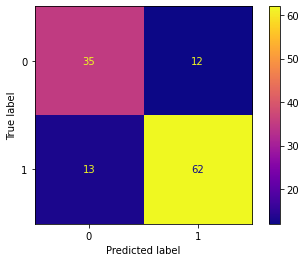

In [46]:
linsvc = LinearSVC(C=0.05, max_iter=2000000000).fit(X_train2, y_train2)
print("Training set score: {:.3f}".format(linsvc.score(X_train2, y_train2)))
print("Test set score: {:.3f}".format(linsvc.score(X_test2, y_test2)))

from sklearn.metrics import classification_report

y_pred2 = linsvc.predict(X_test2)


print(classification_report(y_test2, y_pred2))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.620
Test set score: 0.631
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        35
           1       0.57      0.48      0.52        44
           2       0.70      0.74      0.72        43

    accuracy                           0.63       122
   macro avg       0.63      0.64      0.63       122
weighted avg       0.63      0.63      0.63       122



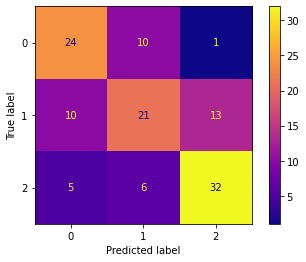

In [10]:
linsvc = LinearSVC(C=50.0, max_iter=2000000000).fit(X_train3, y_train3)
print("Training set score: {:.3f}".format(linsvc.score(X_train3, y_train3)))
print("Test set score: {:.3f}".format(linsvc.score(X_test3, y_test3)))

from sklearn.metrics import classification_report

y_pred3 = linsvc.predict(X_test3)


print(classification_report(y_test3, y_pred3))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test3, y_pred3)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.537
Test set score: 0.418
              precision    recall  f1-score   support

           0       0.56      0.59      0.58        32
           1       0.37      0.52      0.43        29
           2       0.13      0.06      0.09        32
           3       0.47      0.52      0.49        29

    accuracy                           0.42       122
   macro avg       0.38      0.42      0.40       122
weighted avg       0.38      0.42      0.39       122



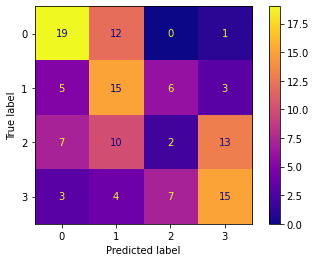

In [11]:
linsvc = LinearSVC(C=0.5, max_iter=2000000000).fit(X_train4, y_train4)
print("Training set score: {:.3f}".format(linsvc.score(X_train4, y_train4)))
print("Test set score: {:.3f}".format(linsvc.score(X_test4, y_test4)))

from sklearn.metrics import classification_report

y_pred4 = linsvc.predict(X_test4)


print(classification_report(y_test4, y_pred4))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test4, y_pred4)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.485
Test set score: 0.508
              precision    recall  f1-score   support

           0       0.56      0.67      0.61        21
           1       0.49      0.73      0.58        26
           2       0.64      0.35      0.45        26
           3       0.41      0.27      0.33        26
           4       0.48      0.57      0.52        23

    accuracy                           0.51       122
   macro avg       0.52      0.52      0.50       122
weighted avg       0.52      0.51      0.49       122



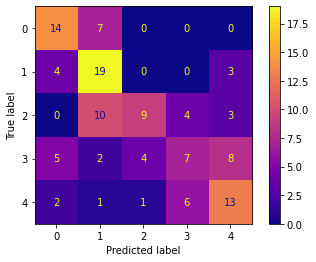

In [12]:
linsvc = LinearSVC(C=100.0, max_iter=2000000000).fit(X_train5, y_train5)
print("Training set score: {:.3f}".format(linsvc.score(X_train5, y_train5)))
print("Test set score: {:.3f}".format(linsvc.score(X_test5, y_test5)))

from sklearn.metrics import classification_report

y_pred5 = linsvc.predict(X_test5)


print(classification_report(y_test5, y_pred5))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test5, y_pred5)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

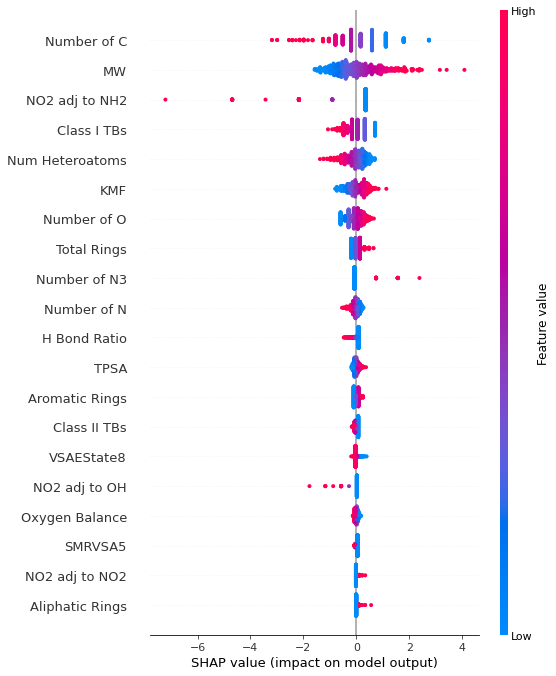

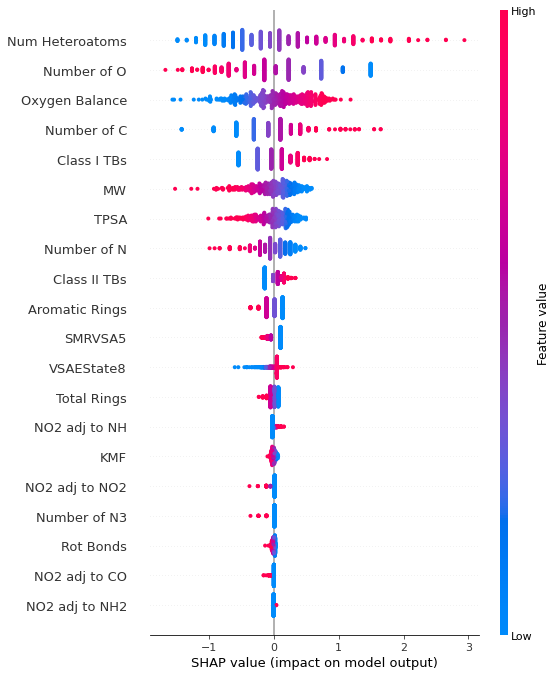

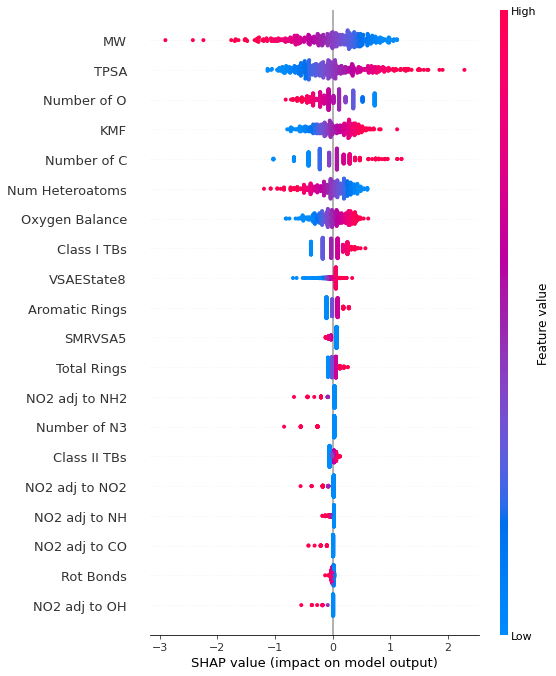

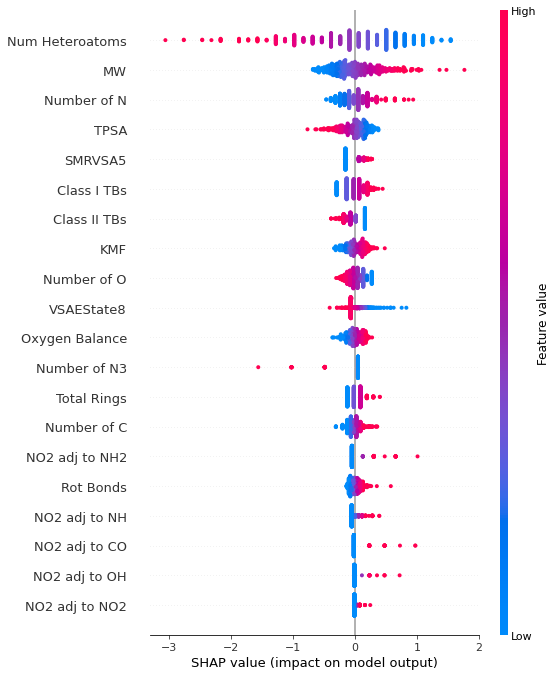

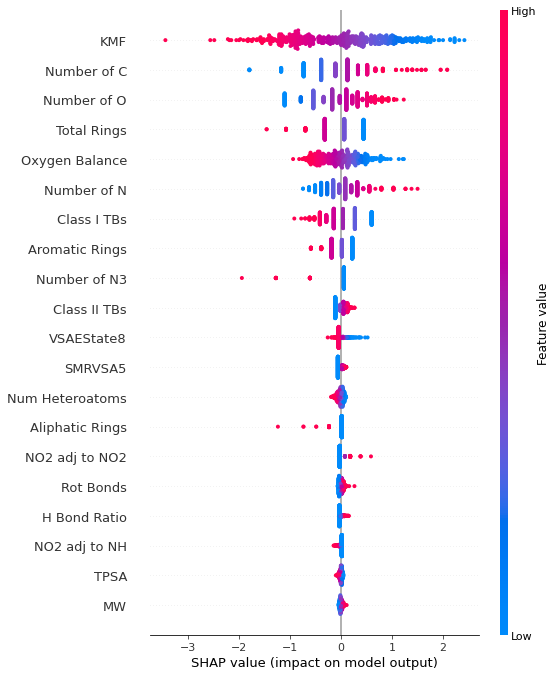

In [13]:
explainer = shap.LinearExplainer(linsvc, X_test5)
shap_values = explainer(features)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], features)


### Logistic Regression

Training set score: 0.741
Test set score: 0.787
              precision    recall  f1-score   support

           0       0.71      0.74      0.73        47
           1       0.84      0.81      0.82        75

    accuracy                           0.79       122
   macro avg       0.77      0.78      0.78       122
weighted avg       0.79      0.79      0.79       122



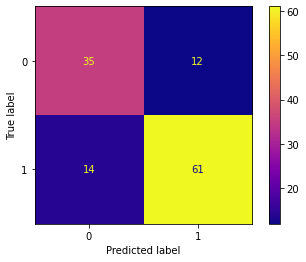

In [61]:
logreg = LogisticRegression(C=1.0, max_iter=10000000).fit(X_train2, y_train2)
print("Training set score: {:.3f}".format(logreg.score(X_train2, y_train2)))
print("Test set score: {:.3f}".format(logreg.score(X_test2, y_test2)))

y_pred2 = logreg.predict(X_test2)

print(classification_report(y_test2, y_pred2))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.617
Test set score: 0.656
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        35
           1       0.58      0.50      0.54        44
           2       0.71      0.79      0.75        43

    accuracy                           0.66       122
   macro avg       0.65      0.66      0.65       122
weighted avg       0.65      0.66      0.65       122



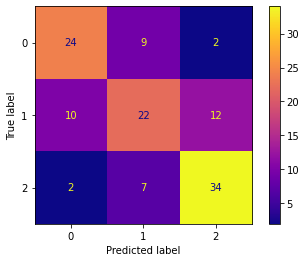

In [16]:
logreg = LogisticRegression(C=1, max_iter=10000000).fit(X_train3, y_train3)
print("Training set score: {:.3f}".format(logreg.score(X_train3, y_train3)))
print("Test set score: {:.3f}".format(logreg.score(X_test3, y_test3)))

y_pred3 = logreg.predict(X_test3)

print(classification_report(y_test3, y_pred3))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test3, y_pred3)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.534
Test set score: 0.484
              precision    recall  f1-score   support

           0       0.65      0.53      0.59        32
           1       0.38      0.52      0.43        29
           2       0.33      0.31      0.32        32
           3       0.65      0.59      0.62        29

    accuracy                           0.48       122
   macro avg       0.50      0.49      0.49       122
weighted avg       0.50      0.48      0.49       122



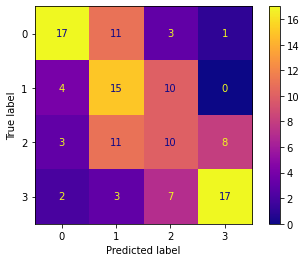

In [17]:
logreg = LogisticRegression(C=1000, max_iter=10000000).fit(X_train4, y_train4)
print("Training set score: {:.3f}".format(logreg.score(X_train4, y_train4)))
print("Test set score: {:.3f}".format(logreg.score(X_test4, y_test4)))

y_pred4 = logreg.predict(X_test4)

print(classification_report(y_test4, y_pred4))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test4, y_pred4)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

Training set score: 0.496
Test set score: 0.500
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        21
           1       0.47      0.69      0.56        26
           2       0.56      0.38      0.45        26
           3       0.38      0.31      0.34        26
           4       0.50      0.52      0.51        23

    accuracy                           0.50       122
   macro avg       0.51      0.51      0.50       122
weighted avg       0.50      0.50      0.49       122



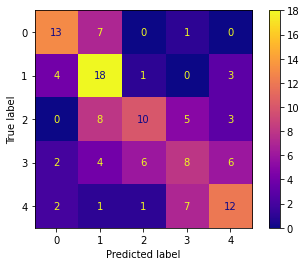

In [18]:
logreg = LogisticRegression(C=10.0, max_iter=10000000).fit(X_train5, y_train5)
print("Training set score: {:.3f}".format(logreg.score(X_train5, y_train5)))
print("Test set score: {:.3f}".format(logreg.score(X_test5, y_test5)))

y_pred5 = logreg.predict(X_test5)

print(classification_report(y_test5, y_pred5))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test5, y_pred5)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

### Random Forests

Accuracy on training set: 0.928
Accuracy on test set: 0.795
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        47
           1       0.84      0.83      0.83        75

    accuracy                           0.80       122
   macro avg       0.78      0.79      0.78       122
weighted avg       0.80      0.80      0.80       122



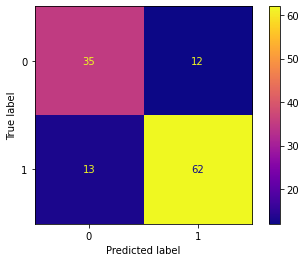

In [63]:
forest = RandomForestClassifier(n_estimators=150, random_state=5, max_features='log2', criterion='entropy', max_depth=7)
forest.fit(X_train2, y_train2)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train2, y_train2)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test2, y_test2)))

y_pred2 = forest.predict(X_test2)
print(classification_report(y_test2, y_pred2))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [20]:
print("RF feature importances:", forest.feature_importances_)

RF feature importances: [0.06340298 0.02827862 0.0286677  0.03340549 0.06041945 0.07106458
 0.19215467 0.04094618 0.02212463 0.02134346 0.00261622 0.03718234
 0.05784479 0.04313    0.07383593 0.05026297 0.04613295 0.07675182
 0.00632159 0.01454552 0.00372189 0.00321055 0.00340446 0.01923122]


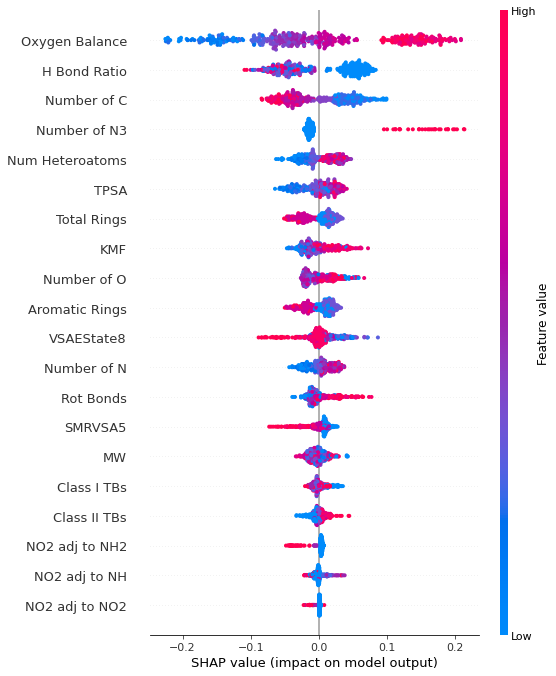

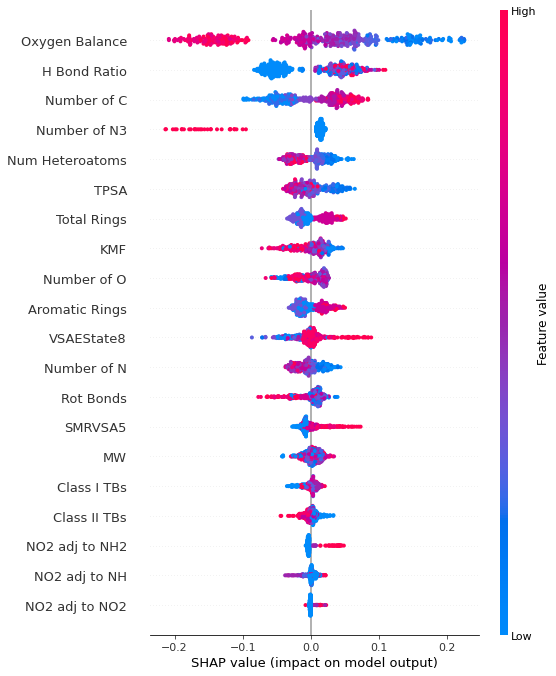

In [69]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer(features)
for i in range(0,2):
    shap.summary_plot(shap_values[:,:,i], features)

Accuracy on training set: 0.821
Accuracy on test set: 0.680
              precision    recall  f1-score   support

           0       0.63      0.77      0.69        35
           1       0.70      0.52      0.60        44
           2       0.72      0.77      0.74        43

    accuracy                           0.68       122
   macro avg       0.68      0.69      0.68       122
weighted avg       0.68      0.68      0.68       122



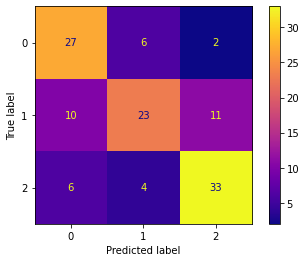

In [22]:
forest = RandomForestClassifier(n_estimators=150, random_state=5, max_features='log2', criterion='entropy', max_depth=5)
forest.fit(X_train3, y_train3)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train3, y_train3)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test3, y_test3)))

y_pred3 = forest.predict(X_test3)
print(classification_report(y_test3, y_pred3))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test3, y_pred3)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [23]:
print("RF feature importances:", forest.feature_importances_)

threeclsrf = forest.feature_importances_
np.savetxt("3clsrfimportances.csv", threeclsrf)

RF feature importances: [0.06845886 0.02957113 0.01780176 0.03067927 0.05324801 0.08851166
 0.20565176 0.04660315 0.02043044 0.01707937 0.00261333 0.04038784
 0.07151146 0.0447316  0.04511692 0.04752595 0.03763695 0.06412761
 0.0066233  0.02772469 0.00311241 0.00361514 0.00596871 0.0212687 ]


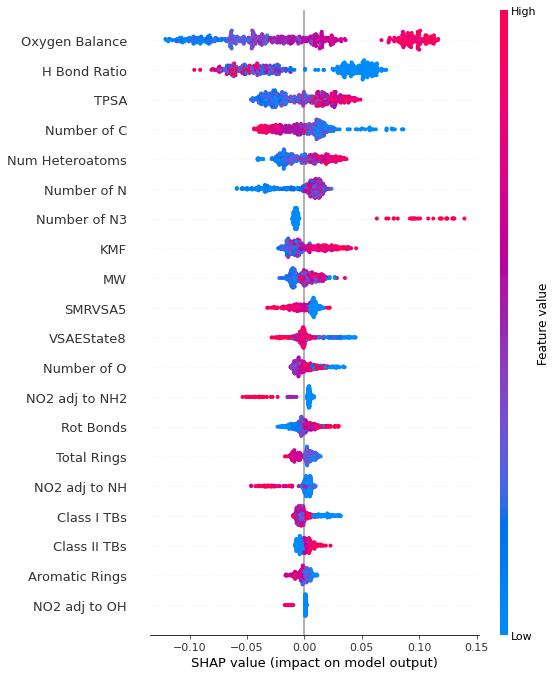

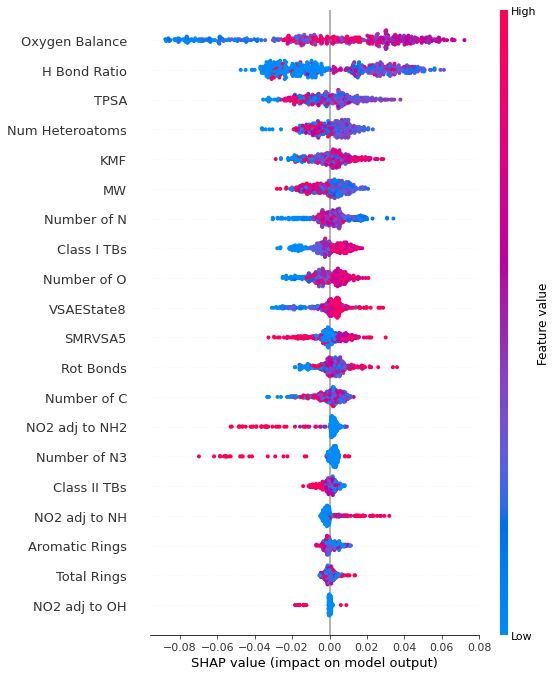

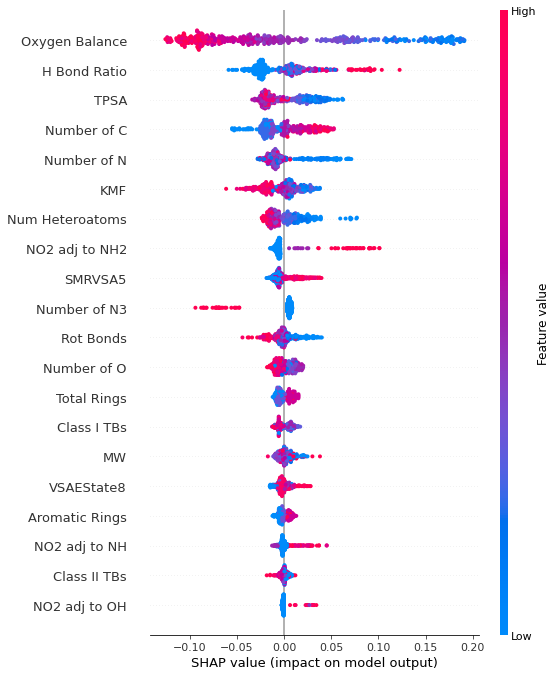

In [24]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer(features)
for i in range(0,3):
    shap.summary_plot(shap_values[:,:,i], features)

Accuracy on training set: 0.997
Accuracy on test set: 0.451
              precision    recall  f1-score   support

           0       0.65      0.53      0.59        32
           1       0.38      0.52      0.43        29
           2       0.34      0.31      0.33        32
           3       0.48      0.45      0.46        29

    accuracy                           0.45       122
   macro avg       0.46      0.45      0.45       122
weighted avg       0.47      0.45      0.45       122



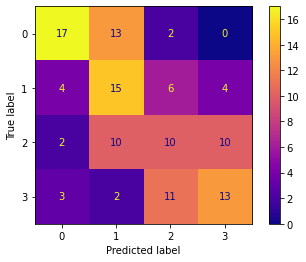

In [25]:
forest = RandomForestClassifier(n_estimators=100, random_state=5, max_features='log2', criterion='entropy', max_depth=9)
forest.fit(X_train4, y_train4)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train4, y_train4)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test4, y_test4)))

y_pred4 = forest.predict(X_test4)
print(classification_report(y_test4, y_pred4))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test4, y_pred4)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')


Accuracy on training set: 0.950
Accuracy on test set: 0.443
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        21
           1       0.39      0.58      0.47        26
           2       0.44      0.31      0.36        26
           3       0.43      0.38      0.41        26
           4       0.48      0.48      0.48        23

    accuracy                           0.44       122
   macro avg       0.45      0.44      0.44       122
weighted avg       0.45      0.44      0.44       122



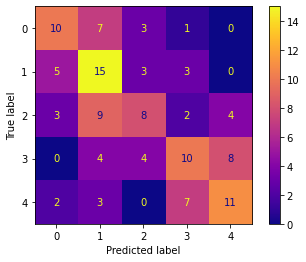

In [26]:
forest = RandomForestClassifier(n_estimators=200, random_state=5, max_features='log2', criterion='gini', max_depth=8)
forest.fit(X_train5, y_train5)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train5, y_train5)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test5, y_test5)))

y_pred5 = forest.predict(X_test5)
print(classification_report(y_test5, y_pred5))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test5, y_pred5)
#print(cm)

from sklearn.metrics import ConfusionMatrixDisplay
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')


In [27]:
print("RF feature importances:", forest.feature_importances_)
fiveclsrf = forest.feature_importances_
np.savetxt("5clsrfimportances.csv", fiveclsrf)

RF feature importances: [0.06933855 0.0372709  0.03525997 0.02700588 0.06887239 0.06414601
 0.1492314  0.05244531 0.02313221 0.02066128 0.00750567 0.04370458
 0.07551756 0.05524844 0.05302548 0.04864204 0.04905132 0.06076031
 0.00925447 0.01334511 0.00375231 0.00419199 0.00400437 0.02463245]


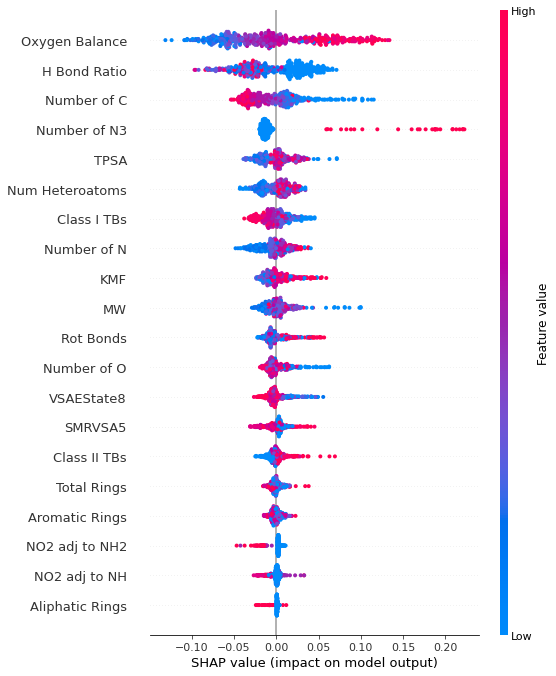

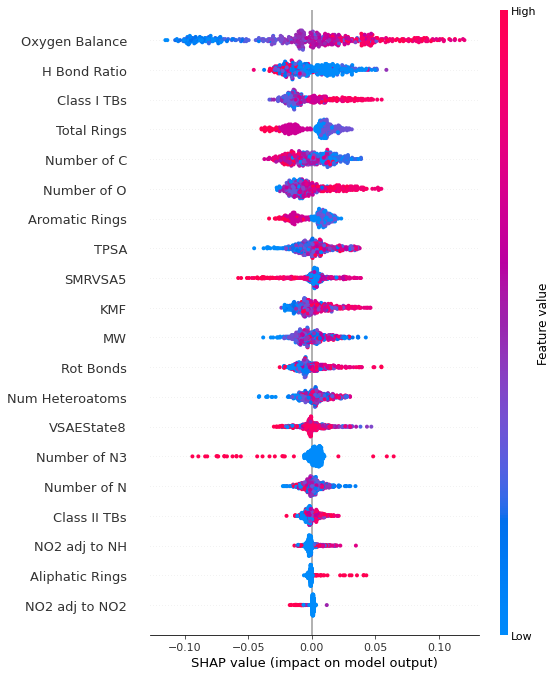

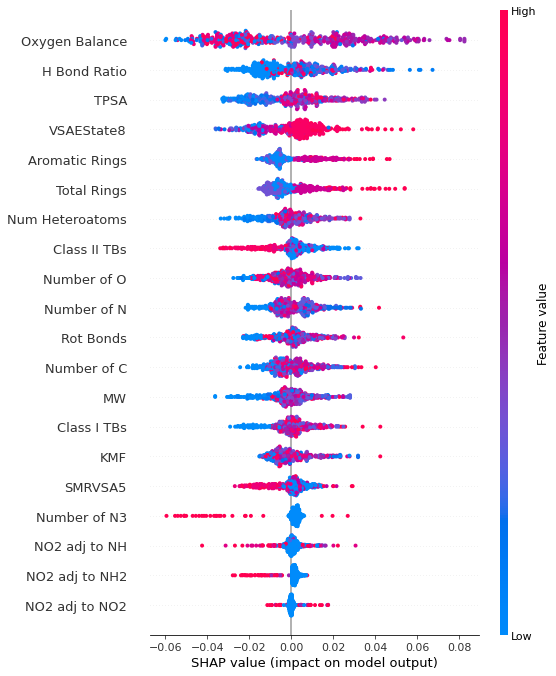

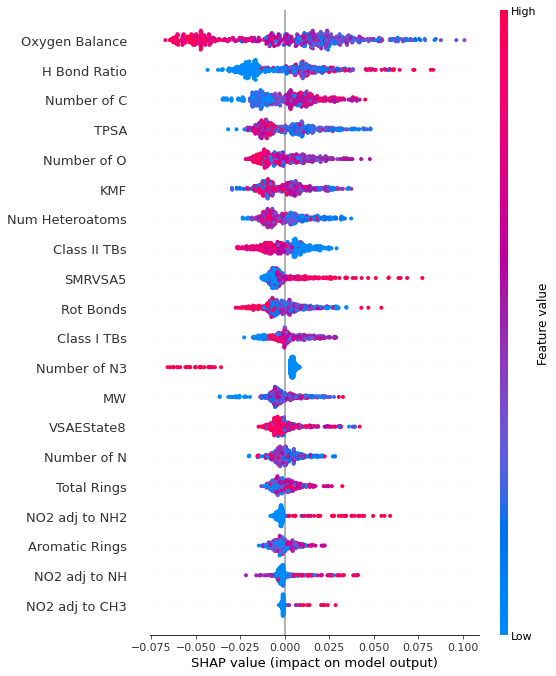

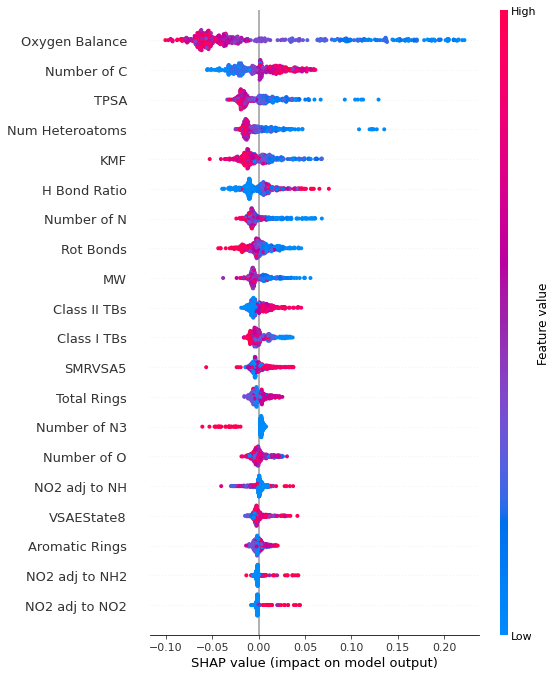

In [28]:
explainer = shap.TreeExplainer(forest)
shap_values = explainer(features)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], features)

## LightGBM

1.0
0.7295081967213115
Confusion matrix

 [[34 13]
 [20 55]]


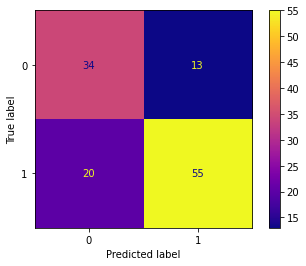

In [67]:
best_params2 = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": 0.883028,
    "num_leaves" : 64,
    'max_depth': 7,
    
    "objective":"binary",
    "verbose":-1
                       
    }

gradtree2 = lgb.LGBMClassifier(**best_params2)
gradtree2.fit(X_train2, y_train2)
scoretrain = gradtree2.score(X_train2, y_train2)
print(scoretrain)


pred2 = gradtree2.predict(X_test2)
#print(pred2)
#print(y_test2)

from sklearn.metrics import accuracy_score
accuracytest = accuracy_score(y_test2, pred2)
print(accuracytest)

cm = confusion_matrix(y_test2, pred2)
print('Confusion matrix\n\n', cm)
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [68]:
print(classification_report(y_test2, pred2))

              precision    recall  f1-score   support

           0       0.63      0.72      0.67        47
           1       0.81      0.73      0.77        75

    accuracy                           0.73       122
   macro avg       0.72      0.73      0.72       122
weighted avg       0.74      0.73      0.73       122



0.9972451790633609
test score:
0.6311475409836066
Confusion matrix

 [[24  9  2]
 [10 25  9]
 [ 4 11 28]]


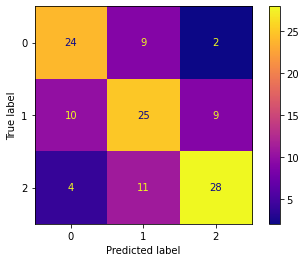

In [31]:
best_params3 = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": 0.4681,
    "num_leaves" : 90,
    'max_depth': 4,
    
    "objective":"multiclass",
    "verbose":-1
                       
    }

gradtree3 = lgb.LGBMClassifier(**best_params3)
gradtree3.fit(X_train3, y_train3)
scoretrain = gradtree3.score(X_train3, y_train3)
print(scoretrain)


pred3 = gradtree3.predict(X_test3)
#print(pred2)
#print(y_test2)

accuracytest = accuracy_score(y_test3, pred3)
print('test score:')
print(accuracytest)

cm = confusion_matrix(y_test3, pred3)
print('Confusion matrix\n\n', cm)
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [32]:
print(classification_report(y_test3, pred3))

              precision    recall  f1-score   support

           0       0.63      0.69      0.66        35
           1       0.56      0.57      0.56        44
           2       0.72      0.65      0.68        43

    accuracy                           0.63       122
   macro avg       0.64      0.64      0.63       122
weighted avg       0.63      0.63      0.63       122



0.9972451790633609
test score:
0.5081967213114754
Confusion matrix

 [[18 10  3  1]
 [ 2 16  7  4]
 [ 2  9 12  9]
 [ 1  3  9 16]]


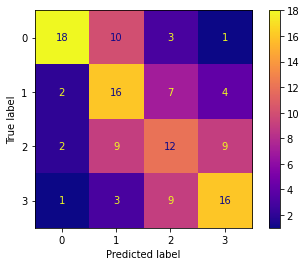

In [33]:
best_params4 = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": 0.9395,
    "num_leaves" : 56,
    'max_depth': 4,
    
    "objective":"multiclass",
    "verbose":-1
                       
    }

gradtree4 = lgb.LGBMClassifier(**best_params4)
gradtree4.fit(X_train4, y_train4)
scoretrain = gradtree4.score(X_train4, y_train4)
print(scoretrain)


pred4 = gradtree4.predict(X_test4)
#print(pred2)
#print(y_test2)

accuracytest = accuracy_score(y_test4, pred4)
print('test score:')
print(accuracytest)

cm = confusion_matrix(y_test4, pred4)
print('Confusion matrix\n\n', cm)
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [34]:
print("GB feature importances:", gradtree4.feature_importances_)

fourclsgb = gradtree4.feature_importances_
np.savetxt("4clsgbimportances.csv", fourclsgb)

GB feature importances: [1458  427  441   65 1044 1089 2192  284  160   97    3  813 1268  690
  784  862  358  521  189   80   30    0    0  439]


In [35]:
print(classification_report(y_test4,pred4))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65        32
           1       0.42      0.55      0.48        29
           2       0.39      0.38      0.38        32
           3       0.53      0.55      0.54        29

    accuracy                           0.51       122
   macro avg       0.53      0.51      0.51       122
weighted avg       0.53      0.51      0.51       122



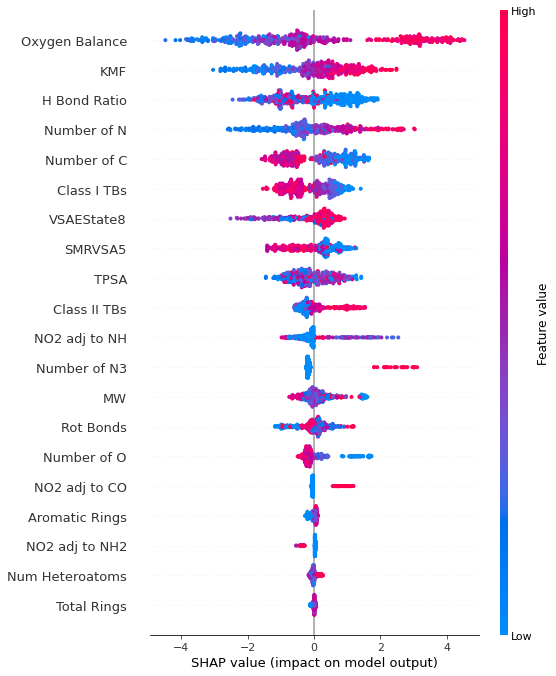

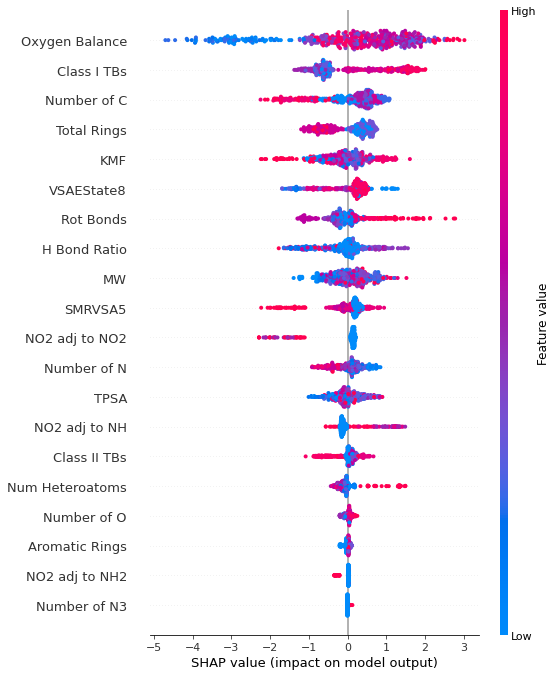

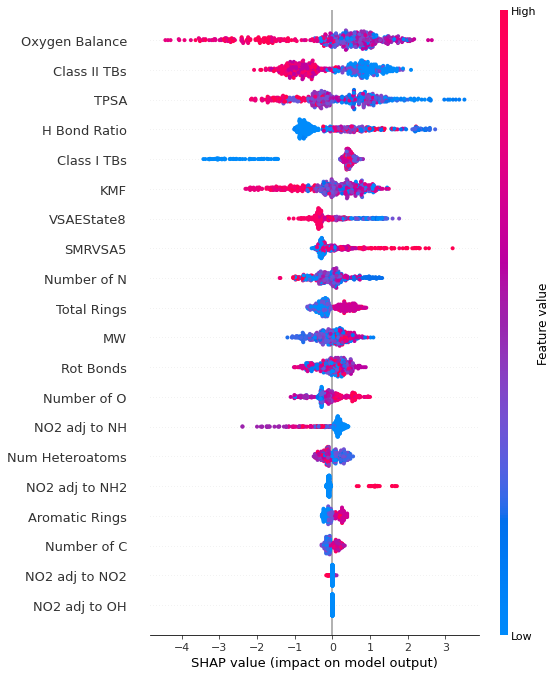

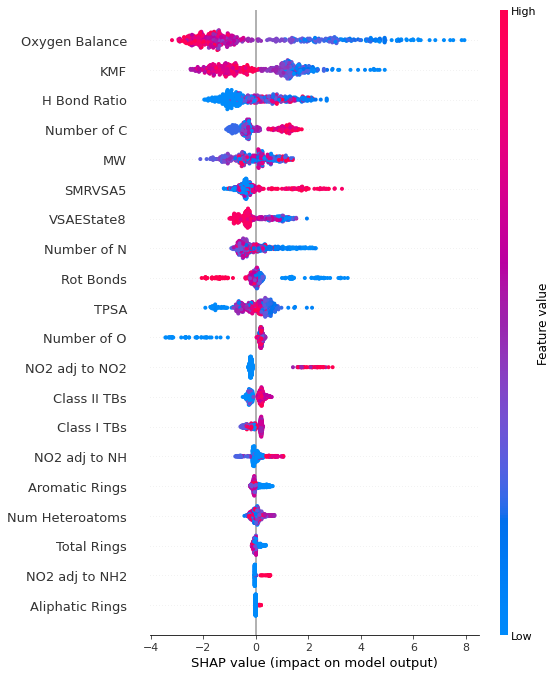

In [36]:
explainer = shap.TreeExplainer(gradtree4)
shap_values = explainer(features)
for i in range(0,4):
    shap.summary_plot(shap_values[:,:,i], features)

0.9944903581267218
test score:
0.45901639344262296
Confusion matrix

 [[12  4  4  1  0]
 [ 5 13  3  5  0]
 [ 1  8  8  3  6]
 [ 2  4  5  9  6]
 [ 1  3  0  5 14]]


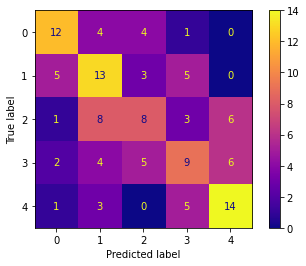

In [37]:
best_params5 = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": 0.9951,
    "num_leaves" : 116,
    'max_depth': 10,
    
    "objective":"multiclass",
    "verbose":-1
                       
    }

gradtree5 = lgb.LGBMClassifier(**best_params5)
gradtree5.fit(X_train5, y_train5)
scoretrain = gradtree5.score(X_train5, y_train5)
print(scoretrain)


pred5 = gradtree5.predict(X_test5)
#print(pred2)
#print(y_test2)

accuracytest = accuracy_score(y_test5, pred5)
print('test score:')
print(accuracytest)

cm = confusion_matrix(y_test5, pred5)
print('Confusion matrix\n\n', cm)
matrix = ConfusionMatrixDisplay(cm)
matrix.plot(cmap='plasma')

In [38]:
print(classification_report(y_test5,pred5))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57        21
           1       0.41      0.50      0.45        26
           2       0.40      0.31      0.35        26
           3       0.39      0.35      0.37        26
           4       0.54      0.61      0.57        23

    accuracy                           0.46       122
   macro avg       0.46      0.47      0.46       122
weighted avg       0.46      0.46      0.45       122



In [39]:
print("GB feature importances:", gradtree5.feature_importances_)

fiveclsgb = gradtree5.feature_importances_
np.savetxt("5clsgbimportances.csv", fiveclsgb)

GB feature importances: [2956  691  668  119 2653 2021 4605  564  323  279    9 1483 2463 1152
 1751 1641  992 1165  431  175   18    0    0 1063]


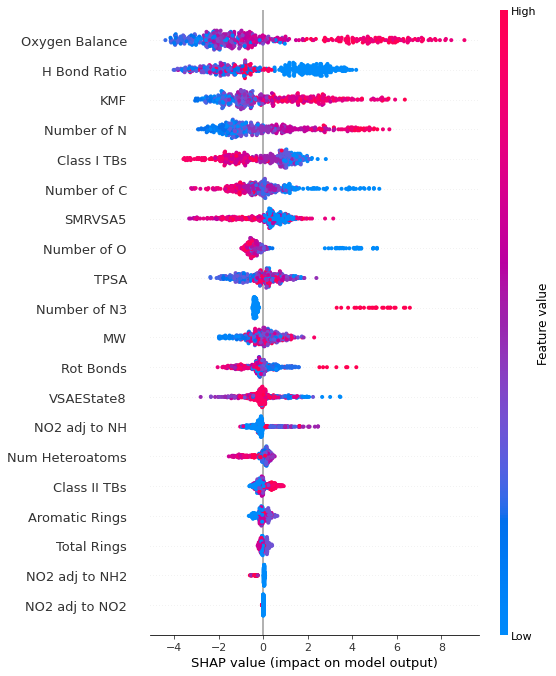

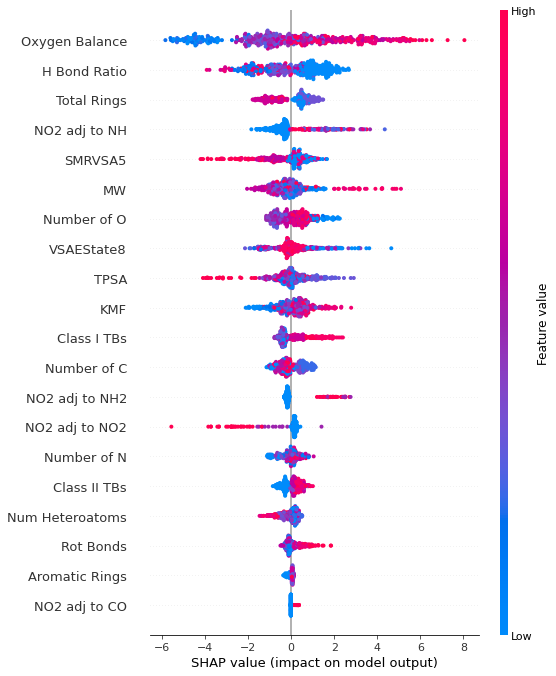

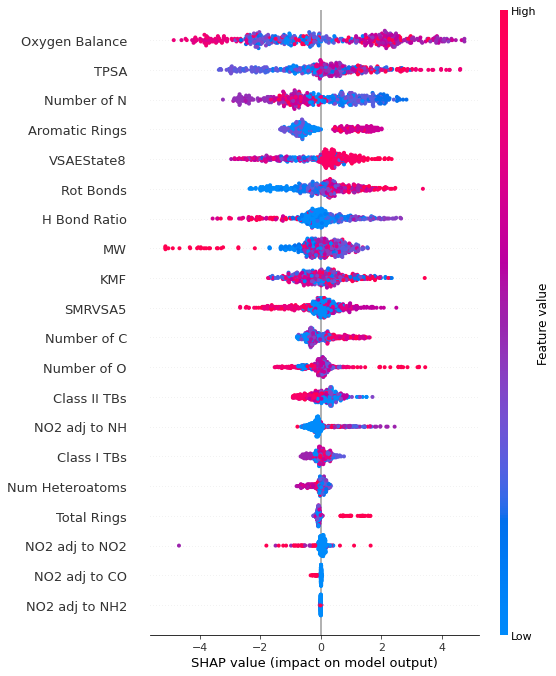

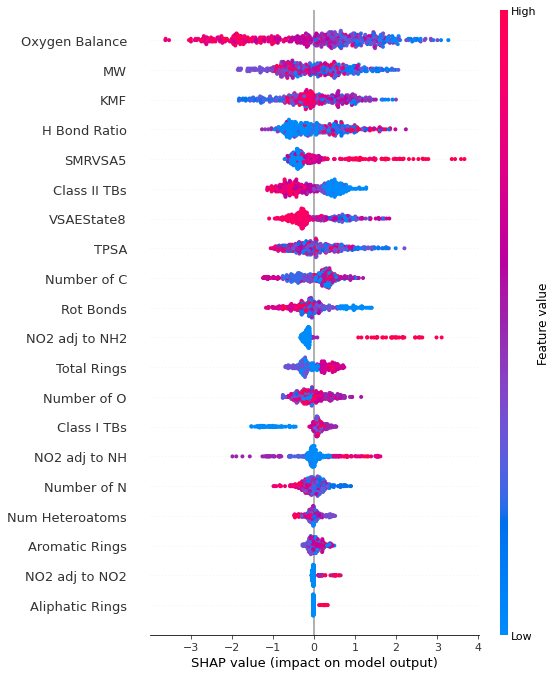

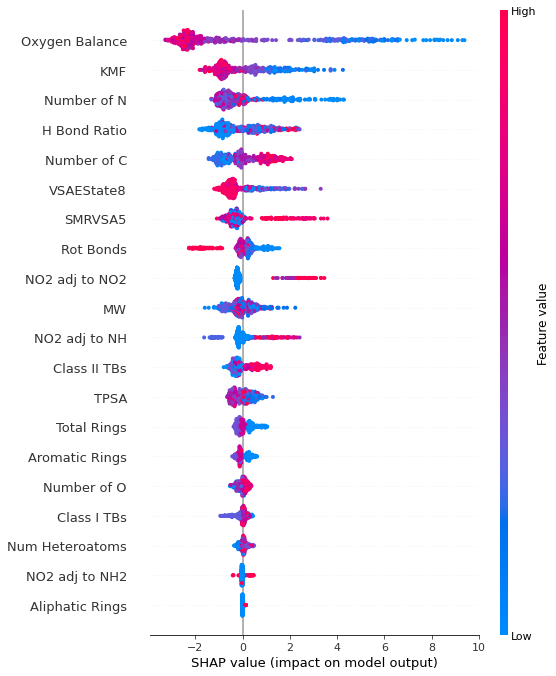

In [40]:
explainer = shap.TreeExplainer(gradtree5)
shap_values = explainer(features)
for i in range(0,5):
    shap.summary_plot(shap_values[:,:,i], features)

## Add additional testing data set here if desired

If interested, a data set of features (after running through the pre-processing notebook) can be used here to find predicted values of sensitivity class, e.g., for new molecules. This uses the best model for each of the 4 classification tasks.

In [30]:
#read in dataframe of preprocessed data from pre-processing notebook (change filename if required)
testfeatures = pd.read_excel('df_additionaltestset.xlsx')
X_testadditional = testfeatures.iloc[:, 1:]

In [32]:
# check data before proceeding (ensure all 24 columns are included for all molecules)
X_testadditional

,KMF,Class I TBs,Class II TBs,Number of N3,MW,H Bond Ratio,Oxygen Balance,Num Heteroatoms,Total Rings,Aromatic Rings,...,VSAEState8,Number of N,Number of O,Number of C,NO2 adj to NO2,NO2 adj to NH2,NO2 adj to CO,NO2 adj to CH3,NO2 adj to OH,NO2 adj to NH
0,0.291237,0.237845,1,0,0.182762,0,0,0.111111,0.4,0,...,0.987109,0.230769,1.609438,1.791759,0,0,0,0,0,0


In [51]:
forest2 = RandomForestClassifier(n_estimators=100, random_state=5, max_features='log2', criterion='entropy', max_depth=7)
forest2.fit(X_train2, y_train2)
# find predicted classes for the added test data, using the model trained on the included data set
y_predtest2 = forest2.predict(X_testadditional)
# print predicted classes (primary (0) or secondary(1)) for the binary model
print(y_predtest2)

[1]


In [34]:
forest3 = RandomForestClassifier(n_estimators=150, random_state=5, max_features='log2', criterion='entropy', max_depth=5)
forest3.fit(X_train3, y_train3)
y_predtest3 = forest3.predict(X_testadditional)
# print predicted classes 0-2 (0 most sensitive, to 1 to 2, least sensitive) for tertiary model
print(y_predtest3)

[2]


In [35]:
best_params4 = {
    # General parameters
    "booster":'gbtree',
    "nthread":16,
    
    # Booster parameters
    "n_estimators":500,          
    "eta":0.01,                            
    "colsample_bytree": 0.9395,
    "num_leaves" : 56,
    'max_depth': 4,
    
    "objective":"multiclass",
    "verbose":-1
                       
    }

gradtree4 = lgb.LGBMClassifier(**best_params4)
gradtree4.fit(X_train4, y_train4)
pred4new = gradtree4.predict(X_testadditional)
# print predicted classes 0-3 (0 most sensitive, to 1 to 2 to 3, least sensitive) for quaternary model
print(pred4new)

[3]


In [36]:
linsvc5 = LinearSVC(C=100.0, max_iter=2000000000).fit(X_train5, y_train5)
y_predtest5 = linsvc5.predict(X_testadditional)
# print predicted classes 0-4 (0 most sensitive, to 1 to 2 to 3 to 4, least sensitive) for quintenary model
print(y_predtest5)

[4]
